<img src="../img/banner.png" width="500" align="center">

# Procesamiento de lenguaje natural
## Predicción de próxima palabra

Preparado por: Alan Churichi

En objetivo de este trabajo es desarrollar un modelo de NLP capaz de predecir la proxima palabra dada una secuencia de texto. Utilizaremos un dataset que contiene mas de 25000 canciones de 150 cantantes distintos. El mismo puede encontrarse en el siguiente [link](https://www.kaggle.com/datasets/terminate9298/songs-lyrics).

In [48]:
%load_ext lab_black

from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


Cargamos el dataset.

In [2]:
lyrics_path = "/tf/notebooks/CEIA/nlp/clase-4/data/lyrics.csv"

df = pd.read_csv(lyrics_path, index_col=0)
df

,link,artist,song_name,lyrics
0,../lyrics/backstreetboys/climbingthewalls.html,Backstreet Boys Lyrics,Climbing The Walls,"\n\n[Brian:]\nClose your eyes, make a wish\nTh..."
1,../lyrics/westlife/howtobreakaheart.html,Westlife Lyrics,How To Break A Heart,\n\r\nSince you're not worth my love\nI haven'...
2,../lyrics/deanmartin/iwill.html,Dean Martin Lyrics,I Will,\n\r\nI don't want to be the one to say I'm go...
3,../lyrics/deanmartin/tellyourmotherhello.html,Dean Martin Lyrics,Tell Your Mother Hello,\n\r\nSure I loved the dear money that shines ...
4,../lyrics/deanmartin/behonestwithme.html,Dean Martin Lyrics,Be Honest With Me,\n\r\nBe honest with me dear whatever you do\n...
...,...,...,...,...
25737,../lyrics/jasonmraz/whatmamasay.html,Jason Mraz Lyrics,What Mama Say,\n\r\n(La la da da da da...)\n\nWhatever mama ...
25738,https://www.azlyrics.com/lyrics/gesaffelstein/...,Gesaffelstein Lyrics,Blast Off,\n\r\nYou've been thinking about this all nigh...
25739,../lyrics/jasonmraz/aworldwithyou.html,Jason Mraz Lyrics,A World With You,\n\r\nLet's hit the road and throw out the map...
25740,../lyrics/jasonmraz/loveisreal.html,Jason Mraz Lyrics,Love Is Real,\n\r\nLove is real it is not just in novels or...


En este caso solo nos interesa la columna 'lyrics'. Vemos una muestra de una canción del dataset.

In [3]:
df["lyrics"][7]

"\n\r\nTogether again my tears have stopped falling\nThe long lonely nights are now at an end\nThe key to my heart you hold in your hand\nAnd nothing else matters we're together again.\n\n(Nothing else matters we're together again.)\n\nTogether again the grey skies are gone\nYou're back in my arms now where you belong\nThe love that I knew is living again\nAnd nothing else matters we're together again.\n\nAnd nothing else matters we're together again.\n(Together again...)\n"

Separando por salto de linea.

In [4]:
df["lyrics"][7].split("\n")

['',
 '\r',
 'Together again my tears have stopped falling',
 'The long lonely nights are now at an end',
 'The key to my heart you hold in your hand',
 "And nothing else matters we're together again.",
 '',
 "(Nothing else matters we're together again.)",
 '',
 'Together again the grey skies are gone',
 "You're back in my arms now where you belong",
 'The love that I knew is living again',
 "And nothing else matters we're together again.",
 '',
 "And nothing else matters we're together again.",
 '(Together again...)',
 '']

Vemos que hay lineas vacias o solo tienen caracteres no imprimibles como \r. Creamos una expresion regular para eliminarlos.

In [5]:
# Remover texto entre () o []
lyrics = [re.sub(r"[\(\[].*?[\)\]]", "", line) for line in df["lyrics"]]
# Remover los caracteres especiales del cominezo y final
lyrics = [re.sub(r"^\W+|\W+$", "", line) for line in lyrics]
# Remover los \n duplicados para evitar tener lineas vacias y separar por estrofas
lyrics = [re.sub(r"\n+", "\n", line).split("\n") for line in lyrics]

lyrics[7]

['Together again my tears have stopped falling',
 'The long lonely nights are now at an end',
 'The key to my heart you hold in your hand',
 "And nothing else matters we're together again.",
 'Together again the grey skies are gone',
 "You're back in my arms now where you belong",
 'The love that I knew is living again',
 "And nothing else matters we're together again.",
 "And nothing else matters we're together again"]

Concatenamos todas las estrofas en un solo vector.

In [6]:
lyrics = [line for lines in lyrics for line in lines]
print(f"Cantidad de estrofas: {len(lyrics)}")
lyrics[:3]

Cantidad de estrofas: 1112852


['Close your eyes, make a wish',
 'That this could last forever',
 'If only you could stay with me now']

Tokenizamos cada linea.

In [7]:
lyrics_word_tokens = [text_to_word_sequence(line) for line in lyrics]
lyrics_word_tokens[:3]

[['close', 'your', 'eyes', 'make', 'a', 'wish'],
 ['that', 'this', 'could', 'last', 'forever'],
 ['if', 'only', 'you', 'could', 'stay', 'with', 'me', 'now']]

Hacemos slices para tener vecotres de 4 tokens, 3 para entrada del modelo y 1 para usar como target.

In [8]:
TRAIN_LEN = 4

text_sequences = []

for line in lyrics_word_tokens:
    if len(line) >= TRAIN_LEN:
        for i in range(TRAIN_LEN, len(line) + 1):
            seq = line[i - TRAIN_LEN : i]
            text_sequences.append(seq)

print(f"Cantidad de secuencias: {len(text_sequences)}")
text_sequences[:10]

Cantidad de secuencias: 4232738


[['close', 'your', 'eyes', 'make'],
 ['your', 'eyes', 'make', 'a'],
 ['eyes', 'make', 'a', 'wish'],
 ['that', 'this', 'could', 'last'],
 ['this', 'could', 'last', 'forever'],
 ['if', 'only', 'you', 'could'],
 ['only', 'you', 'could', 'stay'],
 ['you', 'could', 'stay', 'with'],
 ['could', 'stay', 'with', 'me'],
 ['stay', 'with', 'me', 'now']]

Convertimos los tokens de palabras a valores numéricos.

In [51]:
tok = Tokenizer()
tok.fit_on_texts(text_sequences)

vocab_size = len(tok.word_counts)
print(f"Palabras en el vocabulario: {vocab_size}")

sequences = np.array(tok.texts_to_sequences(text_sequences))
sequences[:10]

Palabras en el vocabulario: 79043


array([[270,  15, 164,  48],
       [ 15, 164,  48,   5],
       [164,  48,   5, 238],
       [ 11,  34,  82, 209],
       [ 34,  82, 209, 374],
       [ 42, 100,   3,  82],
       [100,   3,  82, 179],
       [  3,  82, 179,  22],
       [ 82, 179,  22,   7],
       [179,  22,   7,  50]])

Tomamos los primeros 3 valores de cada muestra como entrada y el último valor como resultado.

In [10]:
X_data = sequences[:, :-1]
y_data = sequences[:, -1]

print(f"Input:\n{X_data[:5]}")
print(f"\nTarget:\n{y_data[:5]}")

Input:
[[270  15 164]
 [ 15 164  48]
 [164  48   5]
 [ 11  34  82]
 [ 34  82 209]]

Target:
[ 48   5 238 209 374]


Tratamos de hacer One-hot encoding para los datos de target.

In [52]:
y_data_sparse = to_categorical(y_data, num_classes=vocab_size)

MemoryError: Unable to allocate 1.22 TiB for an array with shape (4232738, 79043) and data type float32

Si tratamos de convertir el vector target a una matriz de one-hot vemos que el tamaño de la misma es de (4232738, 79043). Esto requeriría una gran cantidad de memoria y sería poco práctico ya que la mayoría de valores serían 0 y no apotrarían información.
Para poder utilizar el vector target con los valores tokenizados como salida deberemos utilizar *sparse_categorical_crossentropy* como función de loss.

Definimos un modelo simple con layers LSTM.

In [14]:
input_seq_len = X_data.shape[1] # 3

model = Sequential()
model.add(Embedding(input_dim=vocab_size + 1, output_dim=5, input_length=input_seq_len))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(32, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

model.summary()

2022-07-25 01:41:26.745740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 01:41:26.763436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 01:41:26.763844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-25 01:41:26.765063: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              395220    
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 79043)             2608419   
                                                                 
Total params: 3,056,663
Trainable params: 3,056,663
Non-

El modelo tiene 3 millones de parámetros entrenables y la cantidad de datos para entrenamiento es de 4 millones. Debido a esto el tiempo que se tarda en entrenar cada epoch será alto y se decidió realizar el entrenamiento solamente durante 15 epochs.

In [15]:
hist = model.fit(X_data, y_data, epochs=15, validation_split=0.2, batch_size=2048)

Epoch 1/15


2022-07-25 01:41:30.418029: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


1654/1654 [==============================] - 245s 147ms/step - loss: 6.8571 - accuracy: 0.0374 - val_loss: 6.6450 - val_accuracy: 0.0383
Epoch 2/15
1654/1654 [==============================] - 242s 146ms/step - loss: 6.1093 - accuracy: 0.0719 - val_loss: 6.2836 - val_accuracy: 0.0746
Epoch 3/15
1654/1654 [==============================] - 241s 146ms/step - loss: 5.7944 - accuracy: 0.0957 - val_loss: 6.1397 - val_accuracy: 0.0905
Epoch 4/15
1654/1654 [==============================] - 242s 146ms/step - loss: 5.6155 - accuracy: 0.1099 - val_loss: 6.0739 - val_accuracy: 0.0997
Epoch 5/15
1654/1654 [==============================] - 241s 146ms/step - loss: 5.4989 - accuracy: 0.1192 - val_loss: 6.0480 - val_accuracy: 0.1072
Epoch 6/15
1654/1654 [==============================] - 240s 145ms/step - loss: 5.4172 - accuracy: 0.1252 - val_loss: 6.0369 - val_accuracy: 0.1105
Epoch 7/15
1654/1654 [==============================] - 241s 146ms/step - loss: 5.3549 - accuracy: 0.1289 - val_loss: 6.043

Realizamos una gráfica para ver como varió el accuracy por epoch.

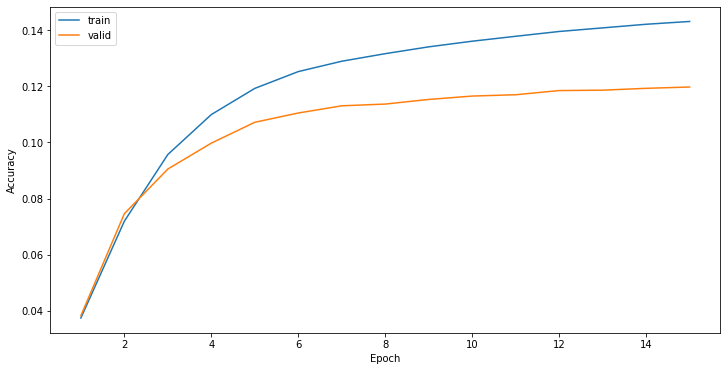

In [54]:
epoch_count = range(1, len(hist.history["accuracy"]) + 1)

plt.figure(figsize=(12, 6))
sns.lineplot(x=epoch_count, y=hist.history["accuracy"], label="train")
sns.lineplot(x=epoch_count, y=hist.history["val_accuracy"], label="valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Definimos una función que haga todo el preprocesamiento necesario y obtenga una predicción dada una sentencia como entrada.

In [17]:
def predict_next(human_text):
    encoded = tok.texts_to_sequences([human_text])[0]
    encoded = pad_sequences([encoded], maxlen=3, padding="pre")
    y_hat = model.predict(encoded, verbose=0).argmax(axis=-1)
    for word, index in tok.word_index.items():
        if index == y_hat:
            return f"{human_text} {word}"
    return None

Probamos generar la siguiente con algunos ejemplos.

In [33]:
predict_next("This is an example of the")

'This is an example of the night'

In [40]:
predict_next("I would like to be a big")

'I would like to be a big man'

In [64]:
text = "I want to be"
for i in range(10):
    text = predict_next(text)

text

'I want to be a little bit of the world that i love you'

Si bien las oraciones obtenidas estan bastante bien formuladas, no tienen mucho sentido. 

El resultado de accuracy en el entrenamiento fue de 11%. Esto podría parecer un valor bajo, pero predecir la siguiente palabra dada una cadena de texto no es una tarea sencilla ya que en la mayoría de casos hay más de una posible respuesta correcta.
Por esto el resultado obtenido no se considera malo.

En este caso decidimos utilizar un modelo simple debido a los costos computacionales y tiempo requeridos para entrenar el modelo. Sin embargo, para lograr mejores valores de accuracy, se podrían probar distintas arquitecturas, agregando más redes LSTM, probando distintos valores de dropout, layers densas, etc. También se podría aumentar el número de epochs de entrenamiento.